# Load raw data and build a cleaned dataset

We’ll use the original file, keep the EEG features + disengagement_risk, drop any missing values, then save to disk as a “clean” CSV.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [25]:
# Load raw file
raw_path = "../data/challenger_insight_eeg_segments_5000.csv"
eeg = pd.read_csv(raw_path)

# Feature columns: ONLY EEG bands + ratios
band_cols = ["delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power"]
ratio_cols = ["theta_alpha_ratio", "beta_alpha_ratio", "theta_beta_ratio"]

feature_cols = band_cols + ratio_cols + ["spectral_entropy"]

# Target
target_col = "disengagement_risk"

# Build clean dataframe
clean_df = eeg[feature_cols + [target_col]].dropna().reset_index(drop=True)

print(clean_df.shape)
print(clean_df.head())

clean_path = "../data/clean_eeg_only_disengagement.csv"
clean_df.to_csv(clean_path, index=False)

print("Saved cleaned EEG-only dataset to:", clean_path)

(5000, 10)
   delta_power  theta_power  alpha_power  beta_power  gamma_power  \
0       2.2473       1.3620       1.5964      0.9354       0.9980   
1       1.6761       1.4147       0.9799      0.9322       0.7717   
2       1.8343       1.6506       1.4633      0.7045       1.0507   
3       1.8669       1.4182       1.5481      0.8320       0.4949   
4       3.1678       0.8671       1.1389      0.8947       0.2875   

   theta_alpha_ratio  beta_alpha_ratio  theta_beta_ratio  spectral_entropy  \
0             0.8526            0.5855            1.4546            0.9669   
1             1.4423            0.9504            1.5159            0.9742   
2             1.1272            0.4811            2.3397            0.9688   
3             0.9155            0.5371            1.7025            0.9444   
4             0.7606            0.7848            0.9681            0.8344   

   disengagement_risk  
0              0.4746  
1              0.4635  
2              0.4964  
3        

In [26]:
print("Cleaned data shape:", clean_df.shape)
print("Columns:", clean_df.columns.tolist())

print("Saved cleaned data to:", clean_save_path)

Cleaned data shape: (5000, 10)
Columns: ['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'theta_alpha_ratio', 'beta_alpha_ratio', 'theta_beta_ratio', 'spectral_entropy', 'disengagement_risk']
Saved cleaned data to: ../data/clean_disengagement_eeg.csv


# Normalization & PCA, T-sne

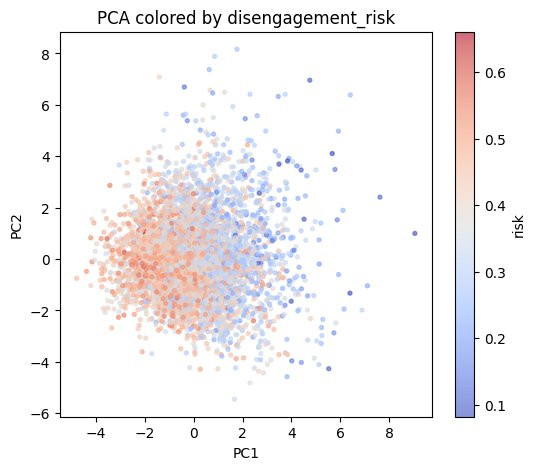

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df[feature_cols])

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clean_df[target], cmap="coolwarm", s=8, alpha=0.6)
plt.title("PCA colored by disengagement_risk")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="risk")
plt.show()


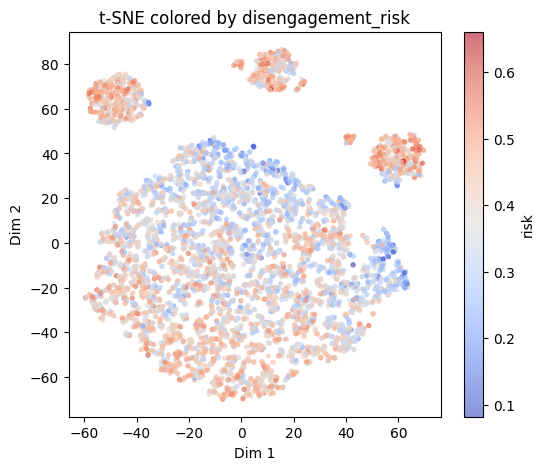

In [12]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clean_df[target], cmap="coolwarm", s=8, alpha=0.6)
plt.title("t-SNE colored by disengagement_risk")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label="risk")
plt.show()


# Train/Test Split & Eval helper

In [28]:
X = clean_df[feature_cols]
y = clean_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [30]:
def eval_reg(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"===== {name} =====")
    print(f"MSE :  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print()


# Models
Model 1 — Linear Regression (with normalization)

Model 2 — Decision Tree Regressor

Model 3 — Random Forest Regressor

In [31]:
# Linear Regression (with normalization)

lin_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

lin_model.fit(X_train, y_train)
pred_lin = lin_model.predict(X_test)
eval_reg(y_test, pred_lin, "Linear Regression")

## Decision Tree Regressor

tree = DecisionTreeRegressor(min_samples_leaf=5, random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
eval_reg(y_test, pred_tree, "Decision Tree")

# Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
eval_reg(y_test, pred_rf, "Random Forest")




===== Linear Regression =====
MSE :  0.0057
RMSE: 0.0757
MAE : 0.0603
R²  : 0.1391

===== Decision Tree =====
MSE :  0.0093
RMSE: 0.0966
MAE : 0.0783
R²  : -0.4022

===== Random Forest =====
MSE :  0.0059
RMSE: 0.0767
MAE : 0.0607
R²  : 0.1155



In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 6],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt", 0.8, 0.6]
}

rf_base = RandomForestRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best Params:", search.best_params_)
print("Best CV Score:", search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/rubyhong/challenger-insight/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
24 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rubyhong/challenger-insight/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rubyhong/challenger-insight/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/rubyhon

Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 5}
Best CV Score: 0.20128420340514974


In [33]:
best_rf = search.best_estimator_
best_rf.fit(X_train, y_train)
pred_rf_tuned = best_rf.predict(X_test)

eval_reg(y_test, pred_rf_tuned, "Tuned Random Forest")


===== Tuned Random Forest =====
MSE :  0.0057
RMSE: 0.0754
MAE : 0.0598
R²  : 0.1446



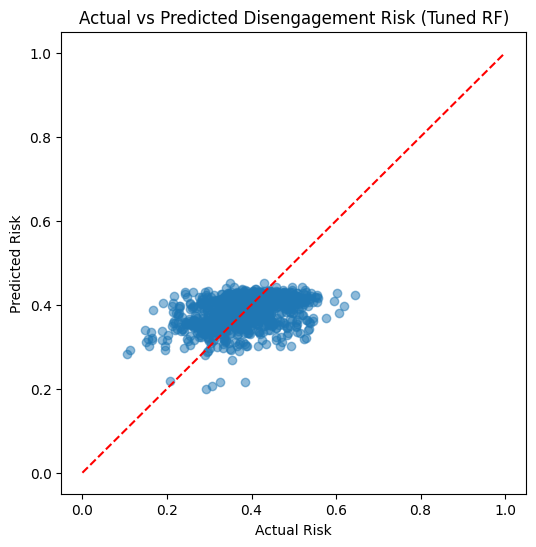

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf_tuned, alpha=0.5)
plt.xlabel("Actual Risk")
plt.ylabel("Predicted Risk")
plt.title("Actual vs Predicted Disengagement Risk (Tuned RF)")
plt.plot([0,1], [0,1], "r--")
plt.show()


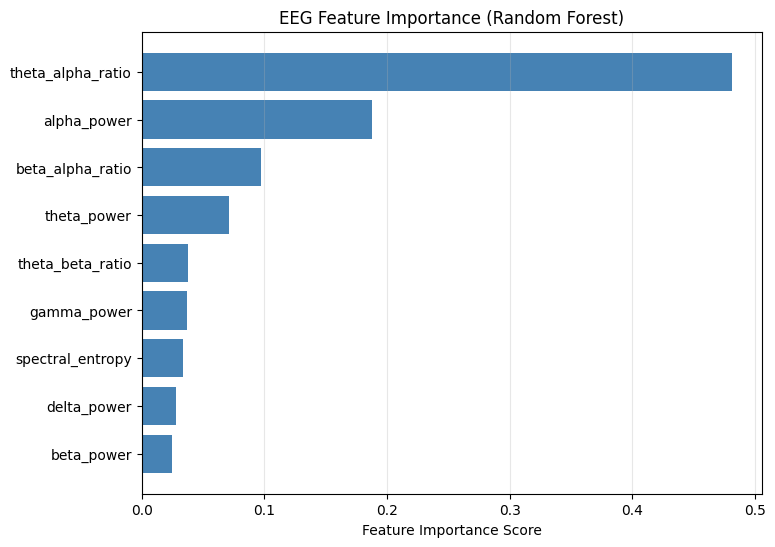

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure you have your fitted model:
# best_rf = search.best_estimator_     # if using tuned RF
# or
# best_rf = rf                         # if using baseline RF

# Feature columns (EEG-only)
band_cols = ["delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power"]
ratio_cols = ["theta_alpha_ratio", "beta_alpha_ratio", "theta_beta_ratio"]
feature_cols = band_cols + ratio_cols + ["spectral_entropy"]

# Extract feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_cols)[indices], importances[indices], color="steelblue")
plt.xlabel("Feature Importance Score")
plt.title("EEG Feature Importance (Random Forest)")
plt.grid(axis="x", alpha=0.3)
plt.show()


After adding spectral entropy, both Linear Regression and Random Forest were evaluated for predicting disengagement_risk. Linear Regression achieved an R² of 0.1391, while the tuned Random Forest improved slightly to an R² of 0.1446 with lower prediction error.

Although the performance gap is small, Random Forest is preferred because it captures mild nonlinear relationships among EEG bands and ratios that Linear Regression cannot model.

Linear Regression has no meaningful hyperparameters, while Random Forest can be further optimized to improve prediction accuracy. Therefore, Random Forest is selected for hyperparameter tuning and final modeling.

# Save

In [40]:
import joblib

joblib.dump(best_rf, "tuned_rf_disengagement.pkl")

['tuned_rf_disengagement.pkl']

In [41]:
best_thresh = 0.26  # from eeg_modeling.ipynb


Make a new dataframe with three artifacts dropped.

In [42]:
df = pd.read_csv("../data/challenger_insight_eeg_segments_5000.csv")

# Columns to drop
drop_cols = [
    "eye_blink_artifact",
    "muscle_artifact",
    "motion_artifact"
]

df_clean = df.drop(columns=drop_cols)

df_clean.to_csv("eeg_dashboard.csv", index=False)

print("Saved:", "eeg_dashboard.csv")
print(df_clean.columns)


Saved: eeg_dashboard.csv
Index(['subject_id', 'session_id', 'segment_idx', 'timestamp', 'role', 'team',
       'modality', 'stimulus_type', 'task_difficulty', 'prior_knowledge_lvl',
       'self_report_engagement_5pt', 'self_report_fatigue_5pt', 'delta_power',
       'theta_power', 'alpha_power', 'beta_power', 'gamma_power',
       'theta_alpha_ratio', 'beta_alpha_ratio', 'theta_beta_ratio',
       'spectral_entropy', 'cognitive_load_score', 'engaged_label',
       'disengagement_risk', 'recommended_trigger'],
      dtype='object')
